<a href="https://colab.research.google.com/github/Khalidmamdou7/CMP637-assignments/blob/main/Notebooks/MNIST-normalizing-flows-NICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from torch.distributions import Uniform, TransformedDistribution
from torch.distributions.transforms import SigmoidTransform, AffineTransform


## Define utility functions

In [6]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False
use_binary_data = False  # two values only {0, 1} or {0, 255}

use_manual_dequantization = True

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

#### saving models helper functions


In [7]:
## Optional TODO: Save the model if you want to store your work on disk and load it later
import torch
from pathlib import Path
from datetime import datetime

def save_checkpoint(
    model,
    optimizer,
    epoch,
    loss=None,
    base_dir="/content/checkpoints",
    prefix="fvsbn"
):
    """
    Saves model + optimizer with timestamp to avoid overwriting.
    """
    base_dir = Path(base_dir)
    base_dir.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{prefix}_epoch{epoch}_{timestamp}.pt"
    path = base_dir / filename

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
        "timestamp": timestamp
    }, path)

    print(f"Checkpoint saved: {path}")
    return path


def load_checkpoint(
    model,
    optimizer=None,
    path=None,
    device="cpu"
):
    """
    Loads model (and optimizer if provided).
    """
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    loss = checkpoint.get("loss", None)

    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss



from google.colab import drive

def mount_gdrive(mount_point="/content/drive"):
    drive.mount(mount_point)
    print("Google Drive mounted")

mount_gdrive()


from pathlib import Path
from datetime import datetime
import torch

def save_checkpoint_gdrive(
    model,
    optimizer,
    epoch,
    loss=None,
    drive_dir="/content/drive/MyDrive/fvsbn_checkpoints",
    prefix="fvsbn"
):
    drive_dir = Path(drive_dir)
    drive_dir.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{prefix}_epoch{epoch}_{timestamp}.pt"
    path = drive_dir / filename

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
        "timestamp": timestamp
    }, path)

    print(f"Checkpoint saved to Google Drive: {path}")
    return path



def load_checkpoint_gdrive(
    model,
    optimizer=None,
    path=None,
    device="cpu"
):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    loss = checkpoint.get("loss", None)

    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss

Mounted at /content/drive
Google Drive mounted


## Load and visualize the dataset

In [8]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Lambda(lambda x: (x > 127).to(torch.uint8) * 255)
        ])
    else:
        transform = transforms.Compose([
            transforms.PILToTensor(),
        ])
else:
    if use_binary_data:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: (x > 0.5).float())
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

if use_manual_dequantization:
    transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float()),
        transforms.Lambda(lambda x: (x + torch.rand_like(x)) / 256)
    ])

# This will load the dataset into the folder "datasets" the first time it is run
train_dataset = torchvision.datasets.MNIST(root="datasets", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="datasets", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

dataset = train_dataset

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]


torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.float32 torch.int64
tensor(8.5216e-08) tensor(1.0000)


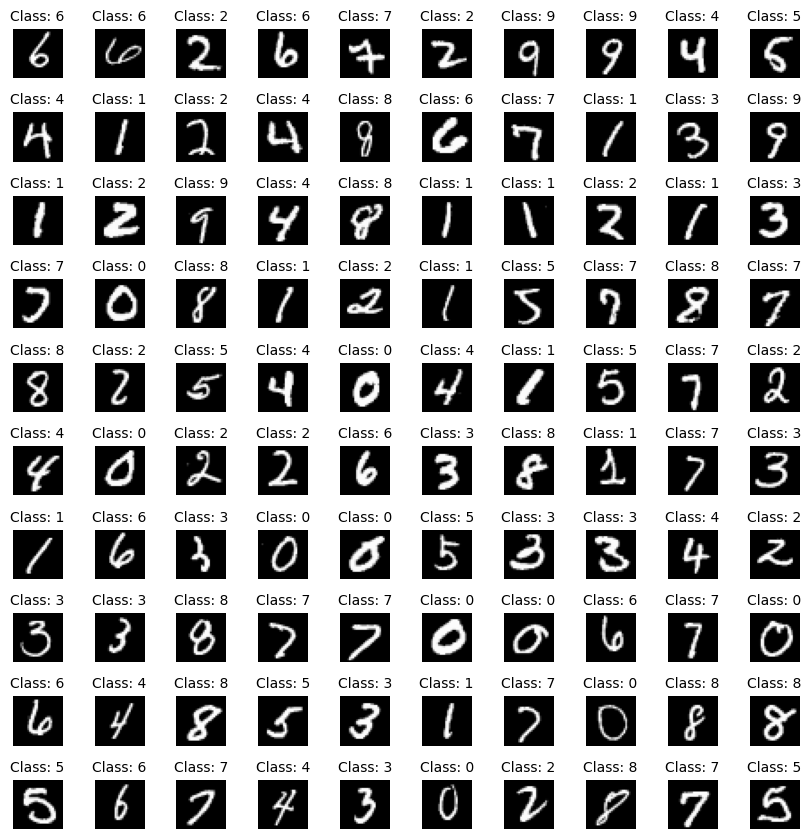

In [9]:
def show_dataset_sample(sample_size: int = 100):
  loader = DataLoader(dataset, batch_size=100, shuffle=True)
  x, y = next(iter(loader))
  print(x.shape, y.shape)
  print(x.dtype, y.dtype)
  print(x.min(), x.max())
#   print(x[0])
#   print(y[0])
  show_images(x, y)

show_dataset_sample()

## Select a device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cpu


## Define the model

In [11]:
class NICE(nn.Module):
    """
    NICE architecture contains coupling layers + Rescaling Layer
    """
    def __init__(self, dim=784):
        super(NICE, self).__init__()
        self.dim = dim
        self.half = self.dim // 2

        self.scaling_layer_diagonals = nn.Parameter(torch.zeros(self.dim))
        self.coupling_layers = nn.ModuleList([
            AdditiveCouplingLayer(dim=self.dim),
            AdditiveCouplingLayer(dim=self.dim),
            AdditiveCouplingLayer(dim=self.dim),
            AdditiveCouplingLayer(dim=self.dim)
        ])

        self.prior_dist = StandardLogisticDistribution()

        self.flatten = nn.Flatten()


    def forward(self, x):
        x = self.flatten(x)
        x1, x2 = x[:, :self.half], x[:, self.half:]

        # print("x1 (nice-ff): ")
        # print(x1.shape)
        # print("x2 (nice-ff): ")
        # print(x2.shape)
        h1_1, h2_1 = self.coupling_layers[0](x1, x2)
        log_pz = self._log_prob_prior(torch.cat((h1_1, h2_1), dim=1))

        h1_2, h2_2 = self.coupling_layers[1](h2_1, h1_1)
        log_pz += self._log_prob_prior(torch.cat((h1_2, h2_2), dim=1))

        h1_3, h2_3 = self.coupling_layers[2](h1_2, h2_2)
        log_pz += self._log_prob_prior(torch.cat((h1_3, h2_3), dim=1))

        h1_4, h2_4 = self.coupling_layers[3](h2_3, h1_3)
        log_pz += self._log_prob_prior(torch.cat((h1_4, h2_4), dim=1))

        h_4 = torch.cat((h1_4, h2_4), dim=1)
        # print("h_4 (nice-ff) device: " + str(h_4.device))
        # print("self.scaling_layer_diagonals device: ", str(self.scaling_layer_diagonals.device))
        h = h_4 * torch.exp(self.scaling_layer_diagonals)


        return h, log_pz

    @torch.no_grad()
    def sample(self, n_samples=10, device='cpu'):
        z = self.prior_dist.sample(n_samples, self.dim).to(device)
        x = self.inverse(z).to(device)
        return x

    def inverse(self, z):
        z = self.flatten(z)
        h_4 = z / torch.exp(self.scaling_layer_diagonals)

        h1_4, h2_4 = h_4[:, :self.half], h_4[:, self.half:]

        h2_3, h1_3 = self.coupling_layers[3].inverse(h1_4, h2_4)
        h1_2, h2_2 = self.coupling_layers[2].inverse(h1_3, h2_3)
        h2_1, h1_1 = self.coupling_layers[1].inverse(h2_2, h1_2)
        x1, x2     = self.coupling_layers[0].inverse(h1_1, h2_1)


        return torch.cat((x1, x2), dim=1)

    def _log_prob(self, z):

        log_pz = self._log_prob_prior(z)
        log_det_fx = self.scaling_layer_diagonals.sum()

        return log_pz + log_det_fx

    def _log_prob_prior(self, z):
        log_pz = - F.softplus(z) - F.softplus(-z)
        log_pz = log_pz.sum(dim=1)
        return log_pz

class AdditiveCouplingLayer(nn.Module):
    """
    y1 = x1
    y2 = x2 + f(x1)
    """
    def __init__(self, dim=784, hidden_layers=5, hidden_units=1000):
        super().__init__()
        self.dim = dim
        self.half = dim // 2

        layers = []
        in_dim = self.half

        # hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_units))
            layers.append(nn.ReLU())
            in_dim = hidden_units

        # output layer (must match x2 size)
        layers.append(nn.Linear(hidden_units, self.half))

        self.f = nn.Sequential(*layers)

    def forward(self, x1, x2):
        y1 = x1
        y2 = x2 + self.f(x1)
        return y1, y2

    def inverse(self, y1, y2):
        x1 = y1
        x2 = y2 - self.f(y1)
        return x1, x2


class StandardLogisticDistribution:
    def __init__(self, loc=0.0, scale=1.0):
        self.loc = loc
        self.scale = scale

        base = Uniform(0, 1)
        transforms = [
            SigmoidTransform().inv,   # logit
            AffineTransform(loc=self.loc, scale=self.scale)
        ]

        self.logistic = TransformedDistribution(base, transforms)

    def sample(self, batch_size, dim):
        return self.logistic.sample((batch_size, dim))

## Define Hyperparameters

In [12]:
# TODO: Define the hyperparameters here.
batch_size = 128
learning_rate = 1e-3
num_epochs = 5 # They used 1500

n_classes = 10
n_dims = 784  # 28x28 MNIST images
hidden_sizes = [512]  # Can try [512, 512] for deeper network
seed = 42

hidden_dim = 1000
num_coupling_layers = 4



## Instantiate models and optimizers

In [13]:
print(device)


model = NICE().to(device)

# model = ConditionalMADE(n_dims=n_dims, n_classes=10, hidden_sizes=hidden_sizes).to(device)
# model = MADE(
#         n_dims=n_dims,
#         hidden_sizes=hidden_sizes,
#         seed=seed
#     ).to(device)
# model = FVSBN(l = 28, w = 28).to(device)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu
Model parameters: 19,158,352


## Train the model

In [14]:
print(model.scaling_layer_diagonals.min().item(),
      model.scaling_layer_diagonals.max().item())


0.0 0.0


In [ ]:

# checkpoint_path = "/content/checkpoints/fvsbn_epoch4_20251224_143015.pt"

# start_epoch, last_loss = load_checkpoint(
#     model=model,
#     optimizer=optimizer,
#     path=checkpoint_path,
#     device=device
# )

# for epoch in range(start_epoch + 1, num_epochs):
#     ...

train_losses = []


model.train()

for epoch in range(1, num_epochs + 1):
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):


        data = data.to(device)


        optimizer.zero_grad()


        # Forward pass: compute log probability
        z, log_pz = model(data)
        log_det_fx = model.scaling_layer_diagonals.sum()
        # Loss: negative log likelihood (we want to maximize log_prob)
        log_px = log_pz + log_det_fx
        loss = -log_px.mean()


        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}')

    avg_loss = train_loss / len(train_loader)
    print(f'====> Epoch {epoch} Average loss: {avg_loss:.4f}')


    # save after each epoch
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        loss=loss.item(),
        prefix='NICE'
    )






def evaluate_conditional_nice(model, test_loader, device):
    """
    Evaluate conditional NICE on test set
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            data = data.float() / 255.0 if data.max() > 1 else data

            _, log_likelihood = model(data, labels, reverse=False)
            test_loss += -log_likelihood.sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    return test_loss

Epoch 1, Batch 0/600, Loss: 4432.3564
Epoch 1, Batch 100/600, Loss: 4315.2344
Epoch 1, Batch 200/600, Loss: 4231.8286
Epoch 1, Batch 300/600, Loss: 4150.3096
Epoch 1, Batch 400/600, Loss: 4069.7883
Epoch 1, Batch 500/600, Loss: 3989.9866
====> Epoch 1 Average loss: 4153.2288
Checkpoint saved: /content/checkpoints/NICE_epoch1_20251227_184125.pt
Epoch 2, Batch 0/600, Loss: 3909.3701


## [Optional] Save and/or load the model

In [ ]:
save_checkpoint_gdrive(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        loss=loss.item(),
        drive_dir='/content/drive/MyDrive/ai-models/gen-ai/nice_checkpoints',
        prefix="NICE"
    )

## Write the generation function

In [ ]:
# Given a tensor of classes y, this function conditionally generates a tensor images.
# Params:
# - y: A tensor of shape [Batch Size] and type int64 and resides on the CPU memory
# Return: A tensor of shape [Batch Size, 1, Height, Width] and type float32
def generate(y: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        batch_size = y.shape[0]
        samples = model.sample(n_samples=batch_size, device=device)
        samples = samples.view(batch_size, 1, 28, 28)
        return samples

## Generate some images and display them

In [ ]:
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)
x = generate(y)
show_images(x, y)

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).

### Loss Function graph

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel("Training step (batch)")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Loss")
plt.grid(True)
plt.show()

